In [17]:
%run nlpUtil.ipynb
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy.interpolate import interp1d
from itertools import cycle

import seaborn as sns
sns.set_style('darkgrid')

This part is for importing data

In [2]:
dt_train = pd.read_excel('DataSets/newsdataset/Data_Train.xlsx')
dt_test = pd.read_excel('DataSets/newsdataset/Data_Test.xlsx')

In [3]:
dt_test.STORY[0].lower()

'2019 will see gadgets like gaming smartphones and wearable medical devices lifting the user experience to a whole new level\n\n\nmint-india-wire consumer technologyconsumer technology trends in new yeartech gadgetsfoldable phonesgaming smartphoneswearable medical devicestechnology\n\n\nnew delhi: gadgets have become an integral part of our lives with most of us relying on some form of factor to communicate, commute, work, be informed or entertained. year 2019 will see some gadgets lifting the user experience to a whole new level. here’s what we can expect to see:\n\n\nsmartphones with foldable screens: foldable phones are finally moving from the concept stage to commercial launches. they are made up of organic light-emitting diode (oled) panels with higher plastic substrates, allowing them to be bent without damage.\n\n\nus-based display maker royole corp’s foldable phone, flexpai, has already arrived in select markets, while samsung’s unnamed foldable phone is expected sometime next 

In [4]:
dt_train['clean_text'] = dt_train['STORY'].apply(words)
dt_train.head(10)

,STORY,SECTION,clean_text
0,But the most painful was the huge reversal in ...,3,"[painful, huge, reversal, fee, income, unheard..."
1,How formidable is the opposition alliance amon...,0,"[formidable, opposition, alliance, among, cong..."
2,Most Asian currencies were trading lower today...,3,"[asian, currencies, trading, lower, today, sou..."
3,"If you want to answer any question, click on ‘...",1,"[want, answer, question, click, ‘answer’, clic..."
4,"In global markets, gold prices edged up today ...",3,"[global, markets, gold, prices, edged, today, ..."
5,BEIJING: Chinese tech giant Huawei has announc...,1,"[beijing, chinese, tech, giant, huawei, announ..."
6,Mumbai: India Inc's external commercial borrow...,3,"[mumbai, india, incs, external, commercial, bo..."
7,"On Wednesday, Federal Reserve Chairman Jerome ...",3,"[wednesday, federal, reserve, chairman, jerome..."
8,What more can you give to the audience? I have...,2,"[give, audience, already, done, yeh, hai, aash..."
9,"com, Arbaaz Khan spoke about getting back to D...",2,"[com, arbaaz, khan, spoke, getting, back, daba..."


In [5]:
cl_text_list = dt_train['clean_text'].tolist()
wf = word_freq(cl_text_list, 20)
wf.head(20)

,0,1
0,said,3707
1,new,1943
2,india,1823
3,congress,1643
4,bjp,1597
5,year,1493
6,one,1479
7,party,1467
8,people,1271
9,would,1231


In [6]:
#Avg word count by category

dt_train['word_count'] = dt_train['STORY'].apply(word_count)
avg_wc = dt_train.groupby('SECTION').mean().reset_index()
avg_wc[['SECTION','word_count']]

,SECTION,word_count
0,0,145.216489
1,1,116.975830
2,2,60.610707
3,3,98.569021


In [7]:
#Preparing the dataframes

#Splitting the df into the different categories
df_business = dt_train.loc[dt_train['SECTION'] == 0] 
df_sports = dt_train.loc[dt_train['SECTION'] == 1]
df_scitech = dt_train.loc[dt_train['SECTION'] == 2] 
df_world = dt_train.loc[dt_train['SECTION'] ==3]

#Randomly sampling business and sports to create imbalanced classes
df_business = df_business.sample(n=1005, random_state=3)
df_sports = df_sports.sample(n=805, random_state=3)

#Holding out 5 articles from each class for prediction at the end
df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

#Appending the dfs back together
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

In [8]:
#Top 15 words by category. Taking bigrams into account

top_n = 15

text_bus = df_business['clean_text'].tolist()
text_sci_t = df_scitech['clean_text'].tolist()
text_sports = df_sports['clean_text'].tolist()
text_world = df_world['clean_text'].tolist()

bus = word_freq_bigrams(text_bus, top_n=top_n)
sci_t = word_freq_bigrams(text_sci_t, top_n=top_n)
sports = word_freq_bigrams(text_sports, top_n=top_n)
world = word_freq_bigrams(text_world, top_n=top_n)

df_wf = pd.concat([bus, sci_t, sports, world], axis=1)
cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
df_wf.columns = cols
df_wf

,business,count,sci tech,count,sports,count,world,count
0,said,413,film,440,said,223,said,454
1,bjp,387,said,283,india,184,year,196
2,congress,380,one,219,new,178,investors,191
3,party,323,actor,196,users,171,market,177
4,lok_sabha,305,films,173,one,154,india,158
5,people,252,movie,163,data,146,ltd,156
6,state,240,time,154,apple,130,may,147
7,one,228,show,153,smartphone,126,company,136
8,elections,218,would,144,company,126,growth,136
9,modi,206,—,141,app,124,shares,126


In [9]:
#Top 15 bigrams by category

bus_bigrams = bigram_freq(text_bus, top_n = top_n)
sci_t_bigrams = bigram_freq(text_sci_t, top_n = top_n)
sports_bigrams = bigram_freq(text_sports, top_n = top_n)
world_bigrams = bigram_freq(text_world, top_n = top_n)

df_bigram_wf = pd.concat([bus_bigrams, sci_t_bigrams, sports_bigrams, world_bigrams], axis=1)
df_bigram_wf.columns = cols
df_bigram_wf

,business,count,sci tech,count,sports,count,world,count
0,lok_sabha,305,avengers_endgame,103,redmi_note,60,oil_prices,60
1,prime_minister,169,captain_america,51,gb_ram,56,story_published,58
2,bharatiya_janata,142,game_thrones,50,last_year,42,wire_agency,58
3,narendra_modi,126,iron_man,47,poco_f,40,feed_without,58
4,new_delhi,121,social_media,41,new_delhi,37,modifications_text,58
5,chief_minister,97,box_office,40,iphone_xs,37,headline_changed,57
6,uttar_pradesh,96,among_others,40,gb_internal,36,far_year,54
7,party_bjp,95,marvel_cinematic,38,ram_gb,30,march_quarter,54
8,rahul_gandhi,92,yearold_actor,33,internal_storage,29,last_year,53
9,election_commission,79,infinity_war,31,samsung_galaxy,29,basis_points,49


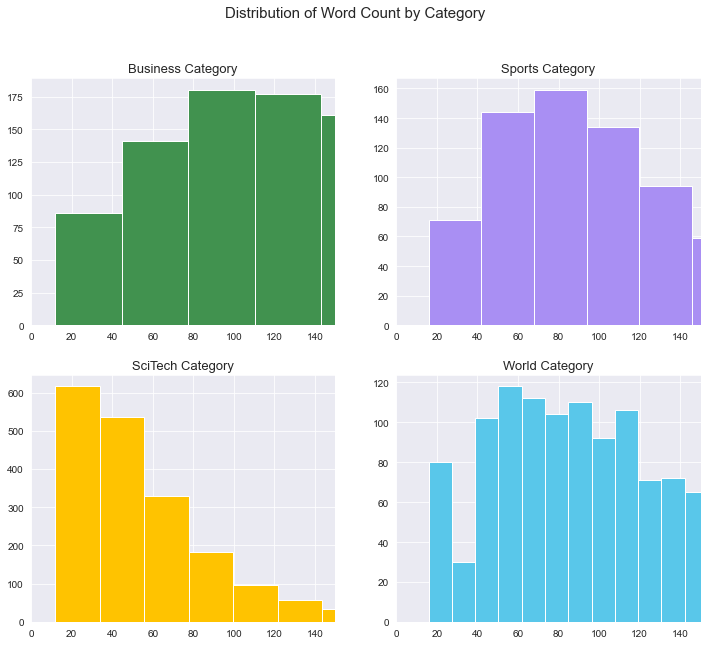

In [10]:
#Plot the distribution of word count by article
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by Category', fontsize=15)

bins = 30

ax[0, 0].hist(df_business['word_count'], bins = bins, color = '#41924F')
ax[0, 0].set_title('Business Category', fontsize = 13)
ax[0, 0].set_xlim(0, 150)

ax[1, 0].hist(df_scitech['word_count'], bins = bins, color = '#FFC300')
ax[1, 0].set_title('SciTech Category', fontsize = 13)
ax[1, 0].set_xlim(0, 150)

ax[0, 1].hist(df_sports['word_count'], bins = bins, color = '#a98ff3')
ax[0, 1].set_title('Sports Category', fontsize = 13)
ax[0, 1].set_xlim(0, 150)

ax[1, 1].hist(df_world['word_count'], bins = bins, color = '#59C7EA')
ax[1, 1].set_title('World Category', fontsize = 13)
ax[1, 1].set_xlim(0, 150)

plt.show()

In [11]:
#Creating the features (tf-idf weights) for the processed text

texts = dt_train['clean_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = dt_train['SECTION'].values #target

print (X.shape)
print(y.shape)

(7628, 71870)
(7628,)


In [12]:
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(7628, 100)

In [13]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

C:\Users\mimishal\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mimishal\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Stochastic Gradient Descent,0.95806,0.962777,0.951461,0.956583
2,Random Forest,0.95806,0.959646,0.951886,0.955531
6,K Nearest Neighbor,0.938838,0.943763,0.934968,0.938001
4,AdaBoost,0.924858,0.921001,0.924872,0.922783
3,Decsision Tree,0.925732,0.926775,0.917384,0.921761
5,Gaussian Naive Bayes,0.859764,0.876528,0.86666,0.864883
0,Dummy,0.363478,0.090869,0.25,0.133291


In [14]:
#Define the best models with the selected params from the grdsearch
#Gridsearch was done on a virtual machine outisde of this notebook
#Normally you can just say 'best_model = gridsearch.best_params_' 
#to use the best parameters from the gridsearch

sgd_best_model = SGDClassifier(alpha=1e-06,
                               loss='log',
                               max_iter=1000,
                               penalty='l2',
                               learning_rate = 'constant',
                               eta0 = .1,
                               random_state = 3,
                               tol=None)

rf_best_model = RandomForestClassifier(bootstrap = False,
                                       max_depth = 50,
                                       max_features = 'auto',
                                       min_samples_leaf = 1,
                                       n_estimators = 1400,
                                       random_state=3)

C:\Users\mimishal\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\mimishal\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\mimishal\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\mimishal\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `los

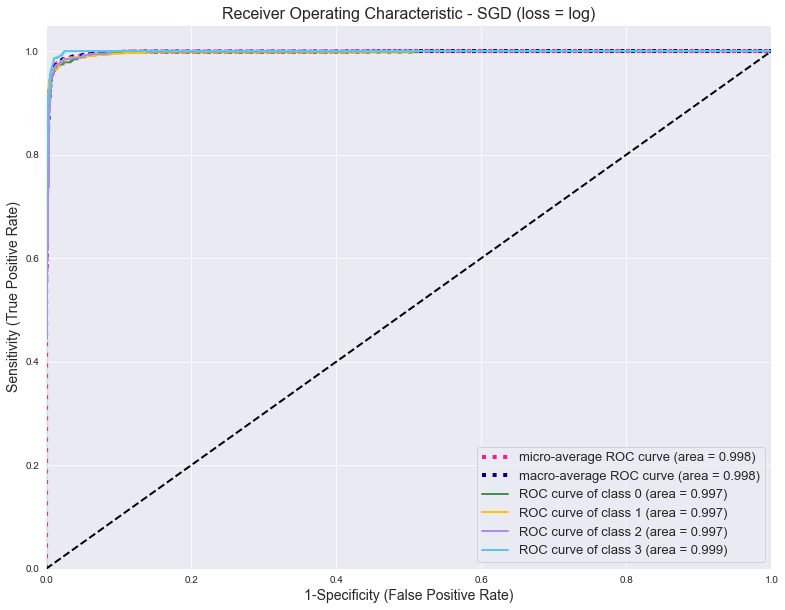

In [21]:
#Plot AUC - SGD

#Binarize the labels
y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1]

#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

#Learn to predict each class against the other
sgd_classifier = OneVsRestClassifier(sgd_best_model)

y_score = sgd_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - SGD (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

C:\Users\mimishal\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


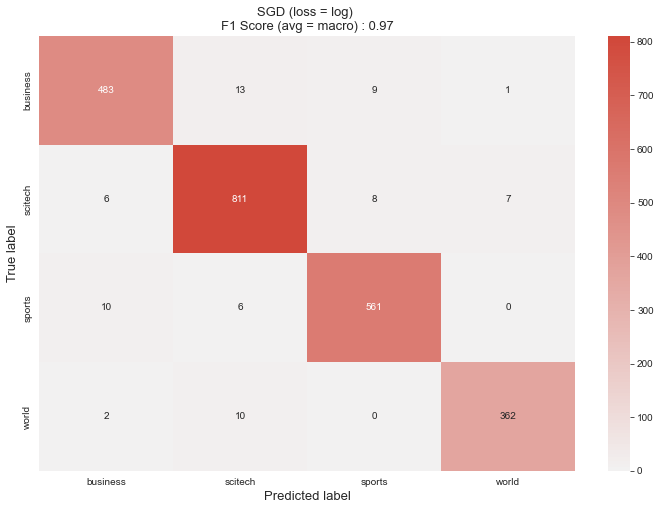

In [22]:
#Confusion Matrix - SGD

#Train test split with stratified sampling. Using non-binarized labels
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)
#Fit the training data
sgd_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = sgd_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['business','scitech','sports', 'world'], 
                     columns = ['business','scitech','sports', 'world'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('SGD (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

In [ ]:
#Plot AUC - RF

#Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(rf_best_model)

y_score = rf_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - RF', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

In [ ]:
#Confusion Matrix - RF

#Fit the training data
rf_best_model.fit(X_train, y_train)

#Predict the testing data
y_pred = rf_best_model.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['business','scitech','sports', 'world'], 
                     columns = ['business','scitech','sports', 'world'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Random Forest \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

In [ ]:
#Putting it all together to make predictions on the unseen text

#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout['clean_text'].astype('str') 

In [ ]:

df_holdout.head(5)

In [ ]:
#Putting it all together to make predictions on the unseen text

#Get the text of the 5 articles we held out from each of the categories in the beginning
unseen = df_holdout['clean_text'].astype('str') 

#Use the saved models to transform the unseen text with tf-idf and lsa
X_unseen_tfidf = tfidf_vectorizer.transform(unseen) 
X_unseen = lsa.transform(X_unseen_tfidf)



In [ ]:
#Fit the models with the best params on the full data
sgd_best_model.fit(X, y)
rf_best_model.fit(X, y)

In [ ]:


#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
dt_test['pred_sgd'] = sgd_best_model.predict(X_unseen)
dt_test['pred_rf'] = rf_best_model.predict(X_unseen)

label_num_dict = {'Business': 0,
                  'SciTech': 1,
                  'Sports': 2,
                  'World': 3}

dt_test['correct'] = dt_test['SECTION'].map(label_num_dict)
dt_test = dt_test.drop('clean_text', 1)
dt_test = dt_test[['content', 'label', 'pred_sgd', 'pred_rf', 'correct']]

dt_test